This notebook replicates Figure 2 in

> __Unsupervised Learning of an Efficient Short-Term Memory Network__  
> Pietro Vertechi\*, Wieland Brendel\*, Christian Machens  
> *Advances in Neural Information Processing Systems 27, 2014*

__License Agreement__  
This program is free software. It comes without any warranty, to
the extent permitted by applicable law. You can redistribute it
and/or modify it.
(Note from ModelDB Admininstrator: this model is released under
a very unrestricted license that lets you do anything with it that
you would like. Contact Wieland Brendel for any license questions.)

__Contact__  
Wieland Brendel  
wieland dot brendel at bethgelab dot org

In [1]:
%pylab inline
from __future__ import division
from numpy import *
from numpy.random import randn, rand, randint

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function
from theano.compile.ops import as_op

from scipy.ndimage.filters import gaussian_filter1d as gfilter

import seaborn as sns
sns.set(style="darkgrid")

from progressbar import ProgressBar

Populating the interactive namespace from numpy and matplotlib


The simulation will take about 15 - 20 minutes on a CPU of a modern workstation. You may opt to run this program on a GPU. In any case, please make sure your Theano package is properly linked against BLAS/LAPACK and activate openmp if required. 

In [2]:
# theano.config.exception_verbosity = 'high'
theano.config.openmp = True

The task is to start with a recurrent neural rate network with random connectivity. The dynamics of the network is described by

$$\dot{\bf r}_t = {\bf F}{\bf x}_t + {\bf\Omega}^d{\bf r}_{t-1} - {\bf\Omega}^f{\bf r}_t - \mu{\bf r}_t.$$

Here $\bf F$ are the feedforward weights, $x_t$ is the input, $\bf\Omega^d$ are the slow recurrent connections and $\bf\Omega^f$ are the fast recurrent connections. For further details, please consider the original publication. We assume that the dynamics of the rates is much faster then the dynamics of the input. Thus, to a first approximation, we can always assume that the network is close to the equilibrium,

$${\bf r}_t = ({\bf\Omega}^f + \mu{\bf I})({\bf F}{\bf x}_t + {\bf\Omega}^d{\bf r}_{t-1}).$$

We use this equation to solve directly for the equilibrium, instead of going through a long gradient descent. To this end, we need to introduce an op for Theano based on the linear Lapack solver dgesv.

In [3]:
from scipy.linalg.lapack import dgesv

In [4]:
def infer_shape_solve(node, input_shapes):
    Ashp, bshp = input_shapes
    return [bshp]

@as_op(itypes=[theano.tensor.dmatrix, theano.tensor.dvector],
       otypes=[theano.tensor.dvector], infer_shape=infer_shape_solve)
def scipy_solve(A, b):
   return dgesv(A,b)[2]

### Parameters & initialization of variables

In this section we initialize the parameters of the network.

In [5]:
N     = 10      # number of neurons
I     = 1       # dimension of inputs

mu2   = 0.15    # regularization of rates ("cost of a spike")
alpha = 0.2     # weight decay (controls the norm of the weights after convergence)

In [6]:
# initial values of rates, input and connection weights
r_init   = zeros((N,))
x_init   = zeros((2,),dtype=float32)
F_init   = randn(N,I)
F_init  /= sqrt(sum(F_init**2,1))[:,None]
Wd_init  = randn(N,N)/float(N**2)/5.
Wf_init  = 3*randn(N,N)/float(N**2)

In [8]:
# time-scales of synaptic plasticity
lam_F    = 0.00001
lam_Wd   = 0.00001
lam_Wf   = 0.001

### Compilation of simulation code using Theano

Theano first builds a symbolic expression of our simulation logic, and then infers an efficient algorithm to implement it (in the compilation step). As a first step, we define the most important variables as Theano symbols.

In [9]:
# define rate (activation of neurons)
r    = T.dvector()

# initialize input as Gaussian-distributed random variable
srng    = RandomStreams(seed=234)
xstream = srng.normal((I,))
x       = T.vector()
noise   = T.scalar()

# initialize noise in neural rates
rstream = srng.normal((N,))

# initialize symbolic connection weights
F  = T.dmatrix("F")
Wf = T.dmatrix("Wf")
Wd = T.dmatrix("Wd")

# symbolic scalar for number of simulation step
k = T.iscalar('k')

The plasticity rules by which the synaptic weights adapt throughout the training are given by

$$\dot{\bf\Omega}^f \propto {\bf F}{\bf x}_t{\bf r}_t^\top + {\bf\Omega}^d{\bf r}_{t-1}{\bf r}_t^\top-\alpha{\bf\Omega}^f$$

$$\dot{\bf F} \propto ({\bf r}_t-\alpha{\bf F}{\bf x}_t){\bf x}_t^\top.$$

$$\dot{\bf\Omega^d} \propto ({\bf r}_t-\alpha{\bf\Omega}^d{\bf r}_{t-1}){\bf r}_{t-1}^\top. $$

The following function is a symbolic description of one step in the simulation.

In [10]:
def training_step(r_tm1, F_tm1, Wf_tm1, Wd_tm1, x_tm1):
    # draw input
    x_t = xstream
    
    # define currents (for notational convenience)
    gslowrecurrent = T.dot(Wd_tm1,r_tm1)
    gforward       = T.dot(F_tm1,x_t)
    
    # update network state
    r_t            = scipy_solve(Wf_tm1 + mu2*T.eye(Wf_tm1.shape[0]),gforward + gslowrecurrent)
    
    # update connection weights
    F_t  = F_tm1 + lam_F *(T.outer(r_t,x_t) - alpha*F_tm1)
    Wf_t = Wf_tm1 + lam_Wf*(T.outer(gforward + gslowrecurrent,r_t) - alpha*Wf_tm1)
    
    Wd_t = Wd_tm1 + lam_Wd*T.outer(r_t - alpha*gslowrecurrent,r_tm1)
        
    return [r_t, F_t, Wf_t, Wd_t, x_t]

Next we stitch together many simulation steps (by means of the Theano scan function) and then compile the graph into the function *training*.

In [11]:
([r_vals, F_vals, Wf_vals, Wd_vals, x_vals], updates) = \
    theano.scan(fn = training_step, \
                outputs_info = [r,F,Wf,Wd,x], \
                n_steps=k)
    
training = function(inputs=[r,F,Wf,Wd,x,k],\
                    outputs=[r_vals[:20], F_vals[-1], Wf_vals[-1], Wd_vals[-1]],\
                    updates=updates)

/usr/local/lib/python2.7/dist-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


We do the same for the testing period, where we aim to record the inputs and the responses of the neurons but leave the synaptic weights fixed.

In [12]:
def testing_step(r_tm1, x_tm1, F, Wf, Wd, noise):
    # draw input
    x_t = xstream
    
    # define currents (for notational convenience)
    gslowrecurrent = T.dot(Wd,r_tm1)
    gforward       = T.dot(F,x_t)
    
    # update network state
    r_t            = scipy_solve(Wf + mu2*T.eye(Wf.shape[0]),gforward + gslowrecurrent) + noise*rstream
    
    return [r_t, x_t]

([r_vals, x_vals], updates) = \
    theano.scan(fn = testing_step, \
                outputs_info = [r,x], \
                non_sequences = [F,Wf,Wd,noise],\
                n_steps=k)

testing = function(inputs=[r,F,Wf,Wd,x,noise,k],\
                    outputs=[r_vals,x_vals],\
                    updates=updates)

### Simulation

In [13]:
r_vals  = [r_init[None,:]]
F_vals  = [F_init]
Wf_vals = [Wf_init]
Wd_vals = [Wd_init]

In [25]:
epochs, epoch_length = 500, 10000
testing_length = 100000

progress = ProgressBar()

for epoch in progress(xrange(epochs)):
    r_out, F_out, Wf_out, Wd_out = training(r_vals[-1][-1,:],F_vals[-1],Wf_vals[-1],Wd_vals[-1],x_init,k=epoch_length)
    r_vals.append(r_out)
    F_vals.append(F_out)
    Wf_vals.append(Wf_out)
    Wd_vals.append(Wd_out)

100% (500 of 500) |#######################| Elapsed Time: 0:15:39 Time: 0:15:39


In [49]:
x_init = zeros(1,dtype=float32)

In [52]:
R, X = testing(r_vals[-1][-1,:],F_vals[-1],Wf_vals[-1],Wd_vals[-1],x_init,0,k=50000)

### Results
#### Basic statistics
First, lets see how the rates change over learning.

In [53]:
# use this variable if you perform multiple trainings (and this accumulate data)
# epochs = 1000

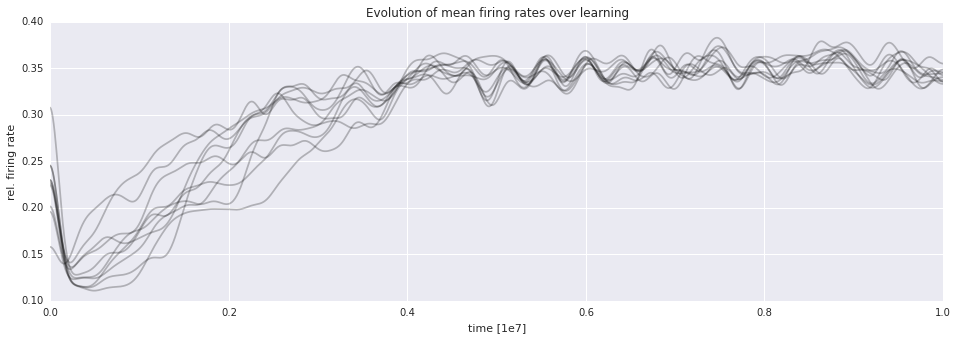

In [54]:
figure(figsize=(16,5))

time = linspace(0,epochs*epoch_length,epochs+1)/1e7
TT = len(time)

for n in xrange(N):
    plot(time,gfilter([mean(abs(r_vals[t][:,n])) for t in xrange(TT)],10),c='black',alpha=0.25)
    
title('Evolution of mean firing rates over learning')
xlabel('time [1e7]')
ylabel('rel. firing rate')
show()

As expected the firing rates goes up over learning as the network learns to keep track of ever more inputs. Next we look at the evolution of the mean synaptic weights over training.

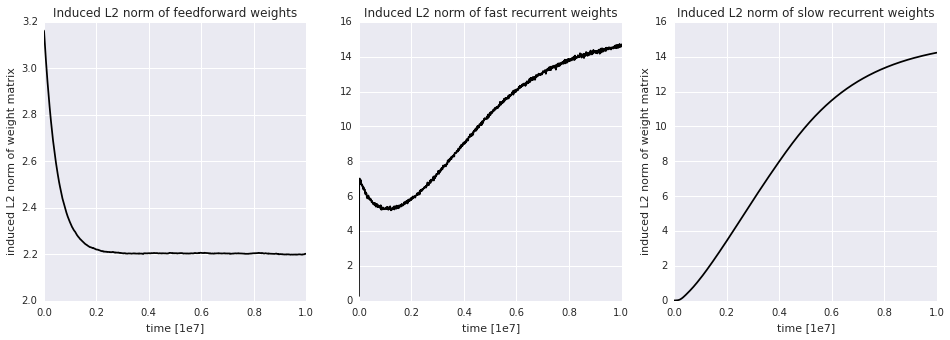

In [55]:
figure(figsize=(16,5))

subplot(131)
plot(time,[sqrt(sum(F**2)) for F in F_vals],c='black')
xlabel('time [1e7]')
ylabel('induced L2 norm of weight matrix')
title('Induced L2 norm of feedforward weights')

subplot(132)
plot(time,[sqrt(sum(Wf**2)) for Wf in Wf_vals],c='black')
xlabel('time [1e7]')
title('Induced L2 norm of fast recurrent weights')

subplot(133)
plot(time,[sqrt(sum(Wd**2)) for Wd in Wd_vals],c='black')
xlabel('time [1e7]')
ylabel('induced L2 norm of weight matrix')
title('Induced L2 norm of slow recurrent weights')

show()


The more (uncorrelated) inputs the network remembers, the more uncorrelated the firing rates will become. Ideally, after learning the rate covariance matrix should be proportional to the unit matrix.

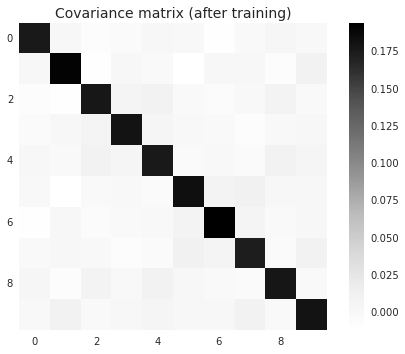

In [57]:
# compute covariance matrix
X, R = vstack(X), vstack(R)
covR = cov(R.T)
fontsize = 14

title('Covariance matrix (after training)',fontsize=fontsize)
imshow(covR,interpolation='nearest', zorder=1)
colorbar()
show()

#### Fixed points of learning



Notice that we can simplify the learning rules above by introducing two auxiliary variables,

$$\dot{\bf D} \propto {\bf x}_t{\bf r}_t^\top - \alpha{\bf D},$$

$$\dot{\bf M} \propto {\bf r}_t{\bf r}_{t-1}^\top - \alpha{\bf M}.$$

At any given fixed point, the synaptic weights are then given by (cp. with the learning rules above and (27) - (29) in the paper),

$${\bf F} = {\bf D}^\top{\bf C}_x^{-1},$$

$${\bf\Omega}^f = {\bf M}^\top{\bf C}_r^{-1},$$

$${\bf\Omega}^d = {\bf D}^\top{\bf D} + {\bf M}^\top{\bf M}.$$

In [59]:
# auxiliary variables
fD   = dot(X.T,R)/alpha/float(R.shape[0])
fM   = dot(R[:-1].T,R[1:])/alpha/float(R.shape[0])

# synaptic weight matrices at fixed points (inputs have unit covariance)
F_fixed  = fD.T
Wd_fixed = dot(fM.T,pinv(covR))
Wf_fixed = dot(fD.T,fD) + dot(fM.T,dot(pinv(covR),fM))

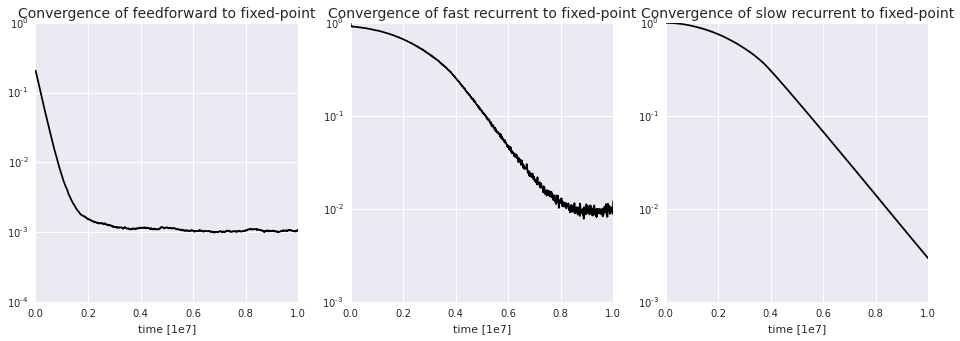

In [60]:
figure(figsize=(16,5))

subplot(131)

title('Convergence of feedforward to fixed-point',fontsize=fontsize)
plot(time,[sum((F_fixed - F_vals[t])**2)/sum(F_fixed**2) for t in xrange(TT)],c='black')
xlabel('time [1e7]')
yscale('log')

subplot(132)

title('Convergence of fast recurrent to fixed-point',fontsize=fontsize)
plot(time,[sum((Wf_fixed - Wf_vals[t])**2)/sum(Wf_fixed**2) for t in xrange(TT)],c='black')
xlabel('time [1e7]')
yscale('log')

subplot(133)

title('Convergence of slow recurrent to fixed-point',fontsize=fontsize)
plot(time,[sum((Wd_fixed - Wd_vals[t])**2)/sum(Wd_fixed**2) for t in xrange(TT)],c='black')
xlabel('time [1e7]')
yscale('log')

Notice that we cheat here a little bit: the rate covariance matrix is computed after learning, and so the convergence within training should not be taken too literally!

How good are the fixed points? Before we evaluate the reconstruction performance on the testing data, an easy test is to see whether the input directions and the slow recurrent connections overlap. Ideally, to avoid signal inference, the two should project into orthogonal subspaces. To test this, we look at the propagation of the two signal directions. Starting from a signal in direction F[:,0] we propagate the signal for N/2 steps by means of the delayed projection matrix Wd. We do the same for the signal in direction F[:,1]. Optimally, the input signal should be projected each time into another, yet unoccupied, orthogonal subspace of the population response. In particular, the signal should never be projected into a subspace that is already occupied by the other signal path (i.e. projections of the other signal direction) nor by previous signals from the same signal path. To test if this is true in the converged solution, we first calculate the signal path:

In [198]:
def get_propagatation_paths(t):
    V0 = [dot(matrix_power(Wd_vals[t],k),F[:,0]) for k in xrange(N//2)]
    V1 = [dot(matrix_power(Wd_vals[t],k),F[:,1]) for k in xrange(N//2)]

    #V0 = [V0[k]/norm(V0[k]) for k in xrange(N//2)]
    #V1 = [V1[k]/norm(V1[k]) for k in xrange(N//2)]

    V0 = vstack(V0)
    V1 = vstack(V1)
    
    return V0, V1

Now we look at the overlaps by showing the matrix of vector products, i.e. the overlap of signal subspaces:

In [203]:
def plot_overlaps_I1(t,figtitle=''):
    V0 = [dot(matrix_power(Wd_vals[t],k),F[:,0]) for k in xrange(N)]
    V0 = [V0[k]/norm(V0[k]) for k in xrange(N)]
    V0 = vstack(V0)
    
    imshow(abs(dot(V0,V0.T)),interpolation='nearest',vmin=0,vmax=1, zorder=1)
    title('Propagation of input direction')
    xlabel('Signal-direction at -x time-steps')
    ylabel('Signal-direction at -y time-steps')

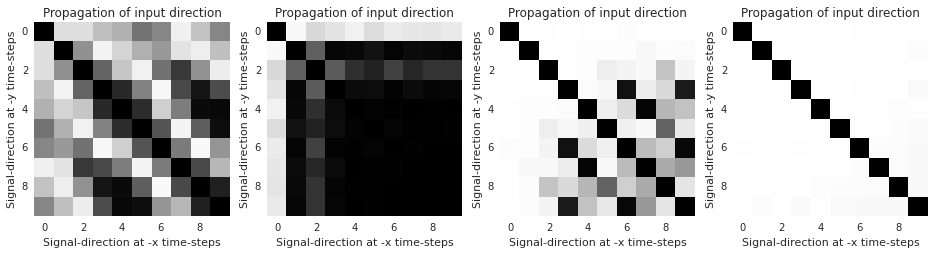

In [204]:
figure(figsize=(16,5))

subplot('141')
plot_overlaps_I1(t=0,figtitle='Overlaps (t=0)')

subplot('142')
plot_overlaps_I1(t=25,figtitle='Overlaps (t=0)')

subplot('143')
plot_overlaps_I1(t=200,figtitle='Overlaps (t=0)')

subplot('144')
plot_overlaps_I1(t=450,figtitle='Overlaps (t=0)')

show()

#### Decoding performance

Finally we look at the how much of the previous inputs to the network we can linearly decode from the instantaneous firing rates of the population. The optimal decoder for inputs $\tau$ time-steps ago was defined as ${\bf D}{\bf M}^{\tau}$. For more details, please consult the original loss function eq. (23).

In [61]:
def get_reconstruction_performance(F,Wf,Wd,testing_length=25000,training_length=10000,opt_dec=False):
    # compute optimal decoders from training data
    R, X = testing(r_init,F,Wf,Wd,x_init,0.025,k=training_length)
    
    D   = dot(X.T,R)/alpha/float(R.shape[0])
    M   = dot(R[:-1].T,R[1:])/alpha/float(R.shape[0]-1)
    
    if not opt_dec:
        decoders = [dot(X.T,pinv(R.T)) if n == 0 else dot(X[:-n].T,pinv(R[n:].T)) for n in xrange(2*N)]
    else:
        decoders = [dot(D,matrix_power(M,n)) for n in xrange(2*N)]
    
    # compute performance on test data
    R, X = testing(r_init,F,Wf,Wd,x_init,0.025,k=testing_length)
    
    errors = empty(2*N)
    
    for n in xrange(2*N):
        Q = decoders[n]
        
        if n == 0:
            errors[n] = sum((X.T - dot(Q,R.T))**2)/sum(X**2)
        else:
            errors[n] = sum((X[:-n].T - dot(Q,R[n:].T))**2)/sum(X[:-n]**2)    
    
    return errors

In [144]:
wm_performance = []
progress = ProgressBar()

for k in progress(xrange(11)):
    t = k*(len(time)//10)
    wm_performance.append(get_reconstruction_performance(F_vals[t],Wf_vals[t],Wd_vals[t],testing_length=5000,training_length=25000))

100% (11 of 11) |#########################| Elapsed Time: 0:01:20 Time: 0:01:20


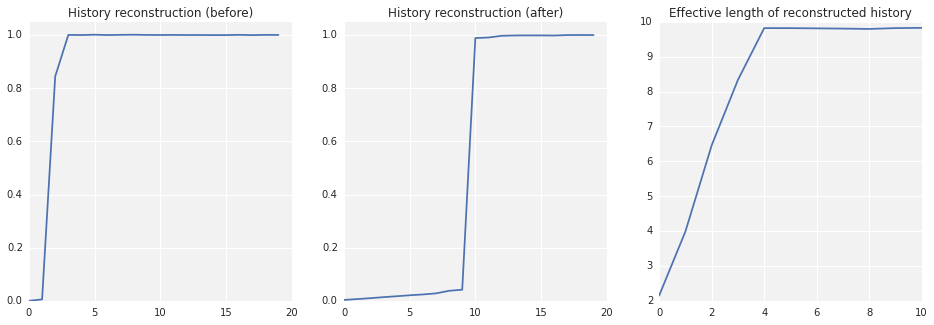

In [197]:
figure(figsize=(16,5))

subplot('131')
title('History reconstruction (before)')
plot(wm_performance[0])
ylim([0,1.05])

subplot('132')
title('History reconstruction (after)')
plot(wm_performance[-1])
ylim([0,1.05])

subplot('133')
title('Effective length of reconstructed history')
K = len(wm_performance)
plot([2*N - sum(clip(wm_performance[n],0,1)) for n in xrange(K)])

show()

### Summary Plot (Figure 2)

In [93]:
import matplotlib.gridspec as gridspec

In [193]:
def plot_overlaps(t,axtitle='',axylabel=True):
    V0 = [dot(matrix_power(Wd_vals[t],k),F[:,0]) for k in xrange(N)]
    V0 = [V0[k]/norm(V0[k]) for k in xrange(N)]
    V0 = vstack(V0)
    
    imshow(abs(dot(V0,V0.T)),interpolation='nearest',vmin=0,vmax=1, zorder=1)
    title(axtitle,fontsize=fontsize)
    xlabel('time-steps in the past',fontsize=labfontsize)
    if axylabel:
        ylabel('time-steps in the past',fontsize=labfontsize)

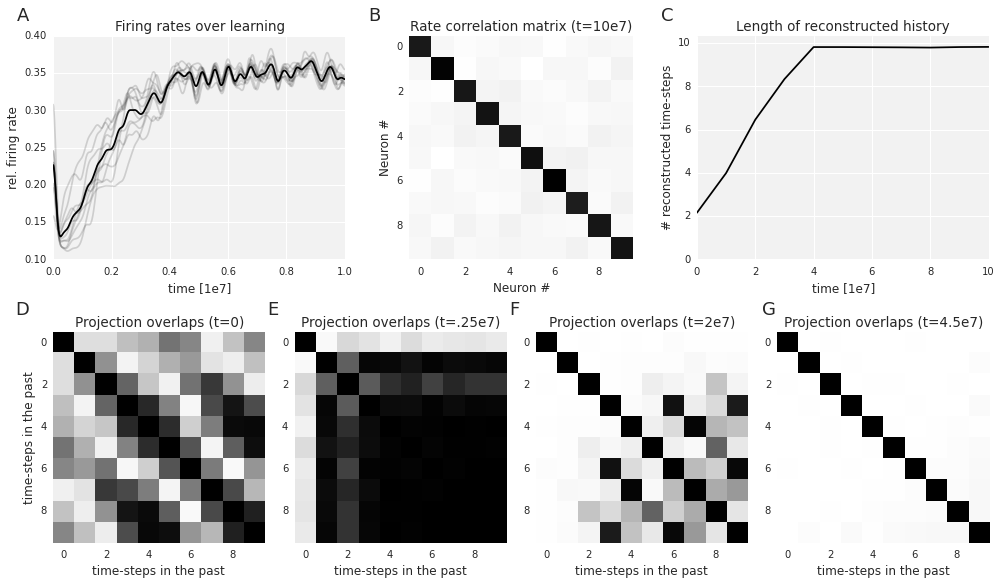

In [196]:
figure(figsize=(14,8))
fontsize=13.5
labfontsize=12

gs = gridspec.GridSpec(2, 12)

ax = plt.subplot(gs[0,:4])
figtext(0.02, 0.98, 'A', fontsize=18)
figtext(0.37, 0.98, 'B', fontsize=18)
figtext(0.66, 0.98, 'C', fontsize=18)

figtext(0.02, 0.47, 'D', fontsize=18)
figtext(0.27, 0.47, 'E', fontsize=18)
figtext(0.51, 0.47, 'F', fontsize=18)
figtext(0.76, 0.47, 'G', fontsize=18)

time = linspace(0,epochs*epoch_length,epochs+1)/1e7
TT = len(time)

sns.set(rc={'axes.facecolor':'0.95'})
for n in xrange(N):
    ax.plot(time,gfilter([mean(abs(r_vals[t][:,n])) for t in xrange(TT)],10),c='black',alpha=0.15)

ax.plot(time,gfilter([mean(abs(r_vals[t])) for t in xrange(TT)],10),c='black')

title('Firing rates over learning',fontsize=fontsize)
xlabel('time [1e7]',fontsize=labfontsize)
ylabel('rel. firing rate',fontsize=labfontsize)

ax = plt.subplot(gs[0,4:8])

title('Rate correlation matrix (t=10e7)',fontsize=fontsize)
imshow(covR,interpolation='nearest', zorder=1)
xlabel('Neuron #',fontsize=labfontsize)
ylabel('Neuron #',fontsize=labfontsize)

ax = plt.subplot(gs[0,8:])
title('Length of reconstructed history',fontsize=fontsize)
K = len(wm_performance)
ax.plot([2*N - sum(clip(wm_performance[n],0,1)) for n in xrange(K)], c='black')
ylim([0,N + N/30])
ylabel('# reconstructed time-steps',fontsize=labfontsize)
xlabel('time [1e7]',fontsize=labfontsize)

ax = plt.subplot(gs[1,:3])
plot_overlaps(t=0,axtitle='Projection overlaps (t=0)')

ax = plt.subplot(gs[1,3:6])
plot_overlaps(t=25,axtitle='Projection overlaps (t=.25e7)',axylabel=False)

ax = plt.subplot(gs[1,6:9])
plot_overlaps(t=200,axtitle='Projection overlaps (t=2e7)',axylabel=False)

ax = plt.subplot(gs[1,9:12])
plot_overlaps(t=450,axtitle='Projection overlaps (t=4.5e7)',axylabel=False)

tight_layout(h_pad=2.5)
savefig('NIPSv7.pdf')
show()